In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import radarmodule as radar
# from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
#from skimage.restoration import unwrap_phase
#import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
import pyart
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# 04/29/16 (IOP4B) case
radar_name = 'KGWX'
radar_lat = 33.896915435791
radar_lon = -88.3291931152344
radar_alt = 179.
radar_type= 'NEXRAD'
date = '0429'
radar_start_datetimestamp = '20160429212000'
radar_end_datetimestamp = '20160430000000'
height = 1000.

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4B/GWX/'
gridded_output_dir = os.path.join(radar_basedir, 'gridded_250m')
if not os.path.exists(gridded_output_dir):
    os.makedirs(gridded_output_dir)
plot_dir = os.path.join(gridded_output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

radar_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

level2_dir = os.path.join(radar_basedir, 'level2')
level2_files = sorted(glob(level2_dir + '/*.ar2v'))
if len(level2_files) == 0:
    level2_files = sorted(glob(level2_dir + '/*V06'))

level2_files_to_read = []
for level2_file in level2_files:
    radar_file_timestamp = os.path.basename(level2_file)[4:19]
    radar_file_datetime = datetime.strptime(radar_file_timestamp, '%Y%m%d_%H%M%S')
    if radar_file_datetime >= datetime_start and radar_file_datetime <= datetime_end:
        level2_files_to_read.append(level2_file)
        print(os.path.basename(level2_file))

KGWX20160429_212347_V06
KGWX20160429_213007_V06
KGWX20160429_213645_V06
KGWX20160429_214315_V06
KGWX20160429_215004_V06
KGWX20160429_215833_V06
KGWX20160429_220453_V06
KGWX20160429_221112_V06
KGWX20160429_221733_V06
KGWX20160429_222352_V06
KGWX20160429_223022_V06
KGWX20160429_223702_V06
KGWX20160429_224322_V06
KGWX20160429_224953_V06
KGWX20160429_225642_V06
KGWX20160429_230332_V06
KGWX20160429_231019_V06
KGWX20160429_231709_V06
KGWX20160429_232359_V06
KGWX20160429_233050_V06
KGWX20160429_233739_V06
KGWX20160429_234358_V06
KGWX20160429_235028_V06
KGWX20160429_235649_V06


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Read PIPS locations from file to generate appropriate bounding box for grid
deployment = 'IOP4B_D1_2016'
PIPS_list = ['PIPS1B', 'PIPS2A', 'PIPS2B']
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15'

PIPS_ds_list = []
PIPS_locs = []

for PIPS in PIPS_list:
    PIPS_filename = 'parsivel_combined_{}_{}_60s.nc'.format(deployment, PIPS)
    PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
    PIPS_ds = xr.load_dataset(PIPS_filepath)
    PIPS_ds_list.append(PIPS_ds)
    PIPS_loc = eval(PIPS_ds.location)
    PIPS_locs.append(PIPS_loc)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Set up grid limits and spacing

# Find PIPS locations in radar coordinates
# PIPS_rad_locs = []
# for PIPS_loc in PIPS_locs:
#     rad_loc = radar.get_PIPS_loc_relative_to_radar(PIPS_loc, radar_lat, radar_lon, radar_alt)
#     PIPS_rad_locs.append(rad_loc)

# PIPS_x = [PIPS_rad_loc[0] for PIPS_rad_loc in PIPS_rad_locs]
# PIPS_y = [PIPS_rad_loc[1] for PIPS_rad_loc in PIPS_rad_locs]
# min_PIPS_x = round(min(PIPS_x))
# max_PIPS_x = round(max(PIPS_x))
# min_PIPS_y = round(min(PIPS_y))
# max_PIPS_y = round(max(PIPS_y))

# xmargin = 75000.
# ymargin = 75000.

# xmin = min_PIPS_x - xmargin
# xmax = max_PIPS_x + xmargin
# ymin = min_PIPS_y - ymargin
# ymax = min_PIPS_y + ymargin

xmin = -123000.
xmax = 123000.
dx = 250.
nx = int((xmax - xmin) / dx) + 1

ymin = -123000.
ymax = 123000.
dy = 250.
ny = int((ymax - ymin) / dy) + 1

zmin = 1000.
zmax = 1000.
dz = 100.
nz = int((zmax - zmin) / dz) + 1
print(nx, ny, nz)

985 985 1


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Test first radar file

print(level2_files_to_read[0])

radar = pyart.io.read_nexrad_archive(level2_files_to_read[0])

grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(nz, ny, nx),
    grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
    fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
    weighting_function='Barnes2')

grid_xr = grid.to_xarray()
# DTD: note that for some reason the conversion to xarray does not preserve the altitude of the grid origin,
# so add it back here as an attribute. Also, create a new coordinate "alt" that is the height of the grid points
# above sea level
origin_altitude = grid.origin_altitude['data'].item()
grid_xr.attrs['origin_altitude'] = origin_altitude
grid_xr = grid_xr.assign_coords(alt=grid_xr.coords['z'] + origin_altitude)
print(grid_xr)

/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2016/NEXRAD/IOP_4B/GWX/level2/KGWX20160429_212347_V06


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:                    (time: 1, x: 985, y: 985, z: 1)
Coordinates:
  * time                       (time) object 2016-04-29 21:23:47.118000
  * z                          (z) float64 1e+03
    lat                        (y) float64 32.78 32.79 32.79 ... 34.99 35.0
    lon                        (x) float64 -89.64 -89.64 ... -87.02 -87.01
  * y                          (y) float64 -1.23e+05 -1.228e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.228e+05 ... 1.23e+05
    alt                        (z) float64 1.179e+03
Data variables:
    differential_reflectivity  (time, z, y, x) float32 nan nan ... 0.2262 0.216
    reflectivity               (time, z, y, x) float32 nan nan ... 23.87 23.65
    cross_correlation_ratio    (time, z, y, x) float32 nan nan ... 0.9748 0.9761
    ROI                        (time, z, y, x) float32 4.605e+03 ... 4.605e+03
Attributes:
    origin_altitude:  179.0


(985, 985) (985, 985) (985, 985)


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


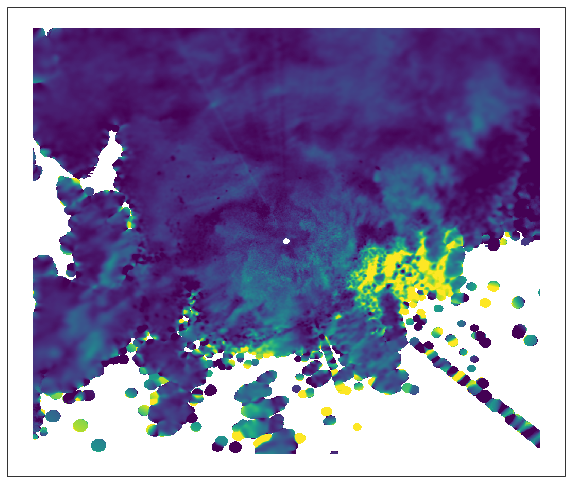

In [20]:
# This seems to broken owing to a possible bug in cartopy with the call to pcolormesh... not sure how to fix it
# right now

display = pyart.graph.GridMapDisplay(grid)

# create the plot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)
x, y = np.meshgrid(grid_xr['lon'], grid_xr['lat'])
dBZ = grid_xr['reflectivity'][0, 0]
print(x.shape, y.shape, dBZ.shape)
pm = ax.pcolormesh(x, y, grid_xr['differential_reflectivity'][0, 0], vmin=0, vmax=6)

# ax.imshow(grid.fields['reflectivity']['data'][0], origin='lower')
# display.plot_grid('reflectivity', 0, vmin=0, vmax=55, projection=projection, cmap="pyart_HomeyerRainbow", ax=ax)
#plt.xlim(-86.7, -85.3)
#plt.ylim(34.0, 36.0)
#start_time = '2017-04-30T20:45'
#end_time = '2017-04-30T20:45'
#plt.title('HTX Time {}'.format(start_time))

# Read in the file, create a RadarMapDisplay object
# fmcw_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'

# Indicate the radar location with a point
# FMCW_lat = 34.3352
# FMCW_lon = -87.2024
# ax.plot([FMCW_lon], [FMCW_lat], color='black', marker='o', transform=ccrs.PlateCarree())


In [ ]:
# Create gridded radar objects and dump to disk
for i, f in enumerate(level2_files_to_read):
    print("On file {:d} of {:d} ({:.2f}%)".format(i+1, len(level2_files), (i+1)/len(level2_files)*100.))
    print("Reading {}".format(os.path.basename(f)))
    radar = pyart.io.read_nexrad_archive(f)
    output_file = os.path.basename(f)[:-5]+"_gridded.nc"
    output_path = os.path.join(gridded_output_dir, output_file)
    
    print("Mapping to grid!")
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
        fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
        weighting_function='Barnes2')
    print("Writing {}".format(output_file))
    pyart.io.write_grid(output_path, grid, arm_time_variables=True, arm_alt_lat_lon_variables=True, 
                        write_point_x_y_z=True, write_point_lon_lat_alt=True)
